In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

Loading BokehJS ...

# Explore Data

In [3]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Hat Yai')
dataset.build_all_data( build_fire=True, build_holiday = True)

th_stations ['44t']
Averaging data from 2 stations



100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 15036.94it/s]

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Loading all hotspots data. This might take sometimes



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:44<00:00,  1.48s/it]


before drop (1772947, 20)
after drop (1737058, 12)



100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 2243.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:28<00:00,  1.03it/s]


before drop (1772947, 20)
after drop (1737058, 12)
Getting holiday for  thailand


In [4]:
# reinit the data and load saved process data 
dataset = Dataset('Hat Yai')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

pollutants to plot Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


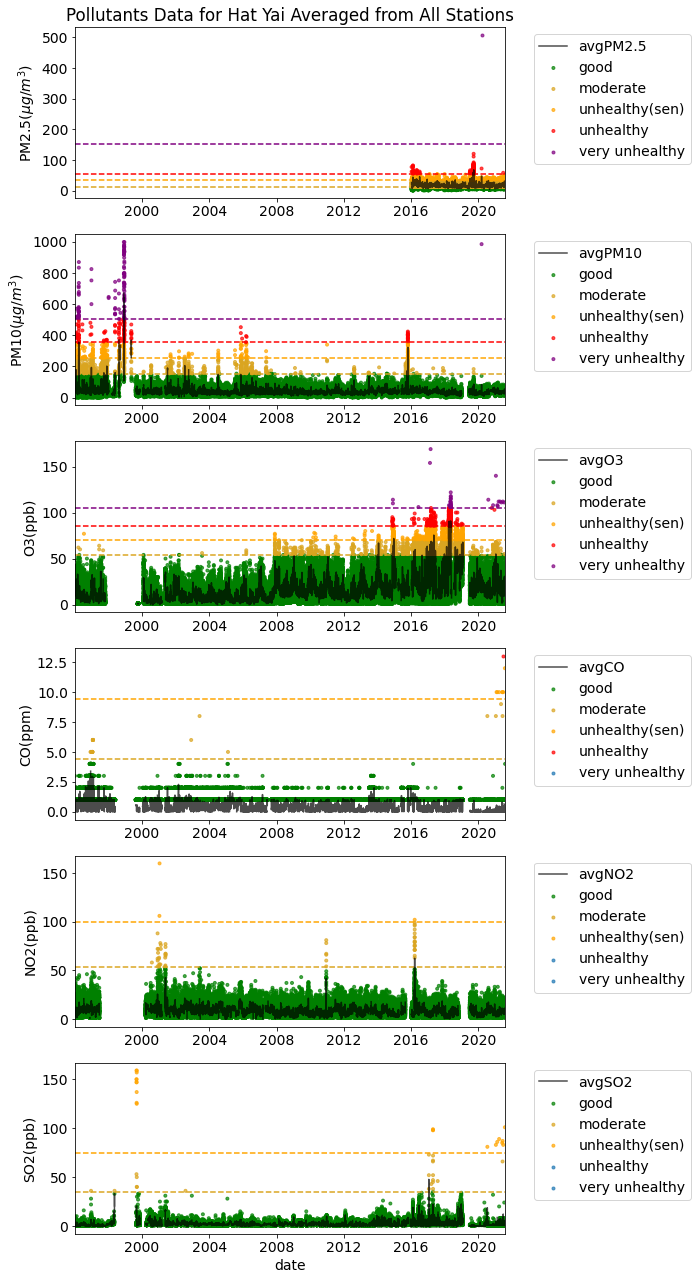

In [5]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

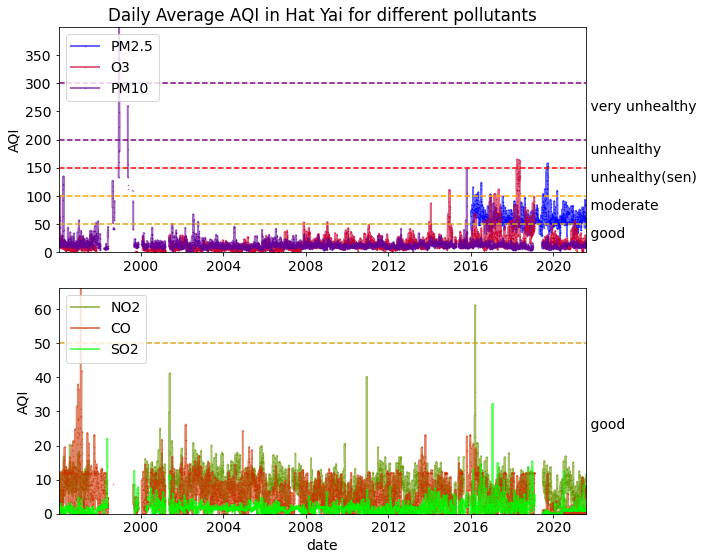

In [6]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

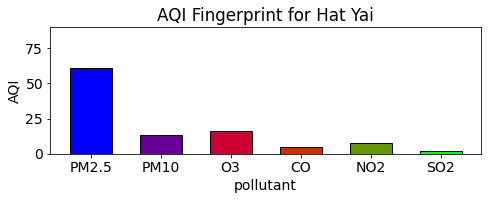

In [7]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

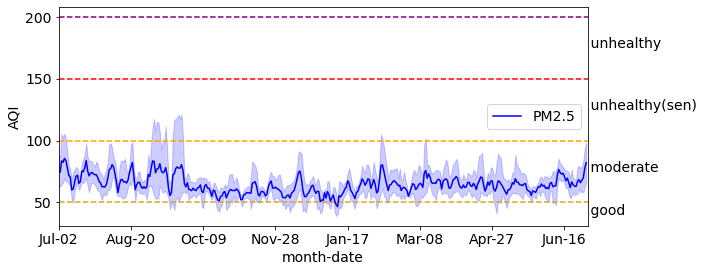

In [8]:
ax, winter_day_dict = plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

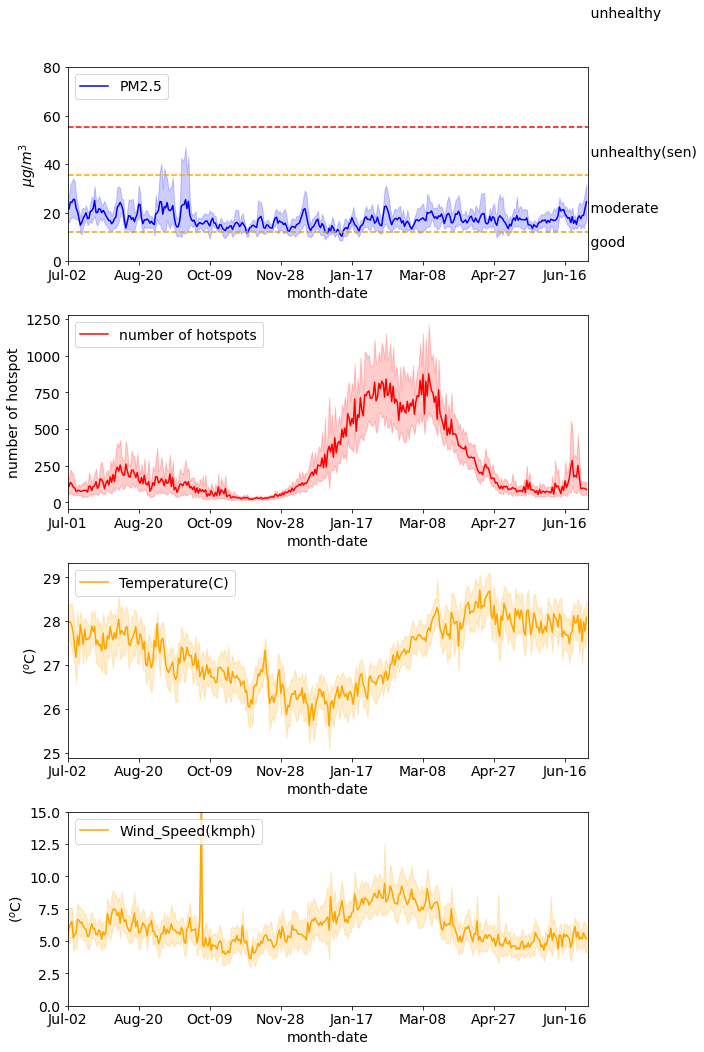

In [9]:
ax = compare_seson_avg(dataset, agg='mean')
ax[0].set_ylim([0, 80])
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

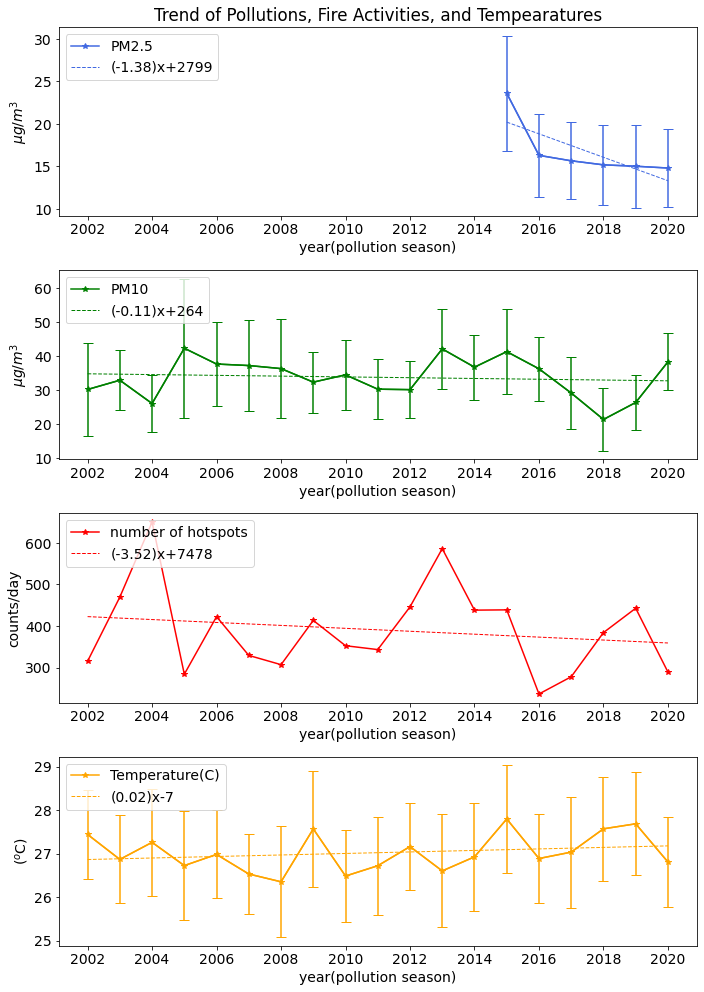

In [10]:
ax, year_avg,  *arg = plot_yearly_ln(dataset, start_month='-11-01', end_month='-04-30', filename=dataset.report_folder + 'compare_ln_trends.png')

In [16]:
dataset.poll_df['PM2.5'].loc['2015-04-14':'2016-12-31'].dropna().head()

datetime
2016-01-10 11:00:00    14.0
2016-01-10 12:00:00    22.0
2016-01-10 13:00:00     7.0
2016-01-10 14:00:00    25.0
2016-01-10 15:00:00    23.0
Name: PM2.5, dtype: float64

# Compare with other province

In [66]:
data_folder = '../data/aqm_hourly_final/'
# station with data before 2018
station_list = ['44t', '62t', '63t', '78t', '80t'   ]
name_list = ['Hatyai',  'Narattiwat', 'Yala\nMuang', 'Yala\nBaetong',  'Satul' ]

85.43600000000879
82.0
86.0
36.91000000000008
73.0


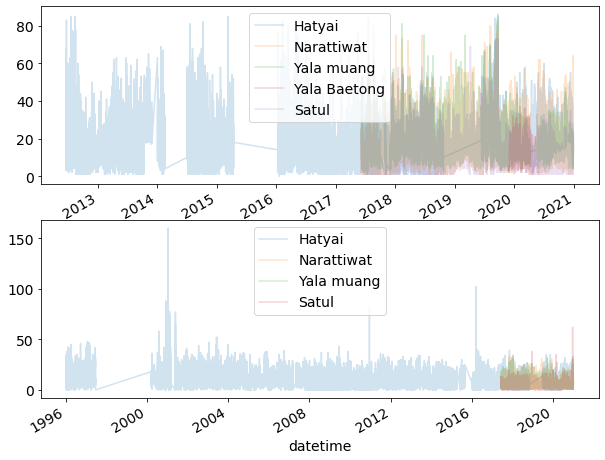

In [59]:
_, ax = plt.subplots(2,1, figsize=(10,8))
for station, name in zip(station_list, name_list):
    df = pd.read_csv(data_folder + station + '.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')
    q99 = df['PM2.5'].quantile(0.999)
    print(q99)
    df[df['PM2.5'] > q99] = np.nan
    df['PM2.5'].dropna().plot(ax=ax[0], alpha=0.2, label=name)
    try:
        df['NO2'].dropna().plot(ax=ax[1], alpha=0.2, label=name)
    except:
        pass
    
for a in ax:
    a.legend()

In [67]:
# append all data into a list 
data_list = []
pm25_all = []
no2_all = []

year = '2017'
for station, name in zip(station_list, name_list):
    df = pd.read_csv(data_folder + station + '.csv')
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.set_index('datetime')
    q99 = df['PM2.5'].quantile(0.999)
    df[df['PM2.5'] > q99] = np.nan
    data_list.append(df)
    
    temp = df.loc[year:][['PM2.5']]
    temp.columns = [name]
    pm25_all.append(temp)
    
    try:
        temp = df.loc[year:][['NO2']]
        temp.columns = [name]
    
        no2_all.append(temp)
    except:
        pass

pm25_all = pd.concat(pm25_all, axis=1)
pm25_all = pm25_all.melt().dropna()

no2_all = pd.concat(no2_all, axis=1)
no2_all = no2_all.melt().dropna()

In [68]:
for i, stat2 in enumerate(name_list[1:]):
    print(f'---Haiyai and {stat2}--(all year)')
    # difference btween two station
    arr1 = data_list[0]['PM2.5'].loc['2017':].dropna().values
    arr2 = data_list[i+1]['PM2.5'].loc['2017':].dropna().values

    t, p = ttest_ind(arr1, arr2, equal_var=False)
    difference = round(np.mean(arr2) - np.mean(arr1), 2)
    mean_drop = round(difference/np.mean(arr1) *100, 2)
    
    print('mean1', round(np.mean(arr1),2), 'mean2', round(np.mean(arr2),2))
    print(difference, 'mean drop (%)', mean_drop)
    print(' t-stat', t, 't-test p value', p)
    #traffic_text_list.append(f'diff = {difference}\ndrop = {mean_drop}%\np = {round(p,2)}')

---Haiyai and Narattiwat--(all year)
mean1 17.83 mean2 14.66
-3.18 mean drop (%) -17.83
 t-stat 38.249481540544856 t-test p value 0.0
---Haiyai and Yala
Muang--(all year)
mean1 17.83 mean2 18.55
0.72 mean drop (%) 4.04
 t-stat -8.915420121602704 t-test p value 5.014726820980865e-19
---Haiyai and Yala
Baetong--(all year)
mean1 17.83 mean2 12.62
-5.22 mean drop (%) -29.27
 t-stat 23.388598110141466 t-test p value 4.839371698151018e-101
---Haiyai and Satul--(all year)
mean1 17.83 mean2 11.95
-5.88 mean drop (%) -32.97
 t-stat 74.90407900675206 t-test p value 0.0


In [70]:
for i, stat2 in enumerate(name_list[1:]):
    print(f'---Haiyai and {stat2}--(all year)')
    if stat2 != 'Yala\nBaetong':
        # difference btween two station
        arr1 = data_list[0]['NO2'].loc['2017':].dropna().values
        arr2 = data_list[i+1]['NO2'].loc['2017':].dropna().values

        t, p = ttest_ind(arr1, arr2, equal_var=False)
        difference = round(np.mean(arr2) - np.mean(arr1), 2)
        mean_drop = round(difference/np.mean(arr1) *100, 2)
    
        print('mean1', round(np.mean(arr1),2), 'mean2', round(np.mean(arr2),2))
        print(difference, 'mean drop (%)', mean_drop)
        print(' t-stat', t, 't-test p value', p)
    #traffic_text_list.append(f'diff = {difference}\ndrop = {mean_drop}%\np = {round(p,2)}')

---Haiyai and Narattiwat--(all year)
mean1 6.55 mean2 5.6
-0.94 mean drop (%) -14.36
 t-stat 25.2049850788668 t-test p value 2.517585541163977e-139
---Haiyai and Yala
Muang--(all year)
mean1 6.55 mean2 5.3
-1.24 mean drop (%) -18.94
 t-stat 33.6029134428648 t-test p value 8.266054641183955e-245
---Haiyai and Yala
Baetong--(all year)
---Haiyai and Satul--(all year)
mean1 6.55 mean2 3.28
-3.27 mean drop (%) -49.95
 t-stat 99.785194941763 t-test p value 0.0


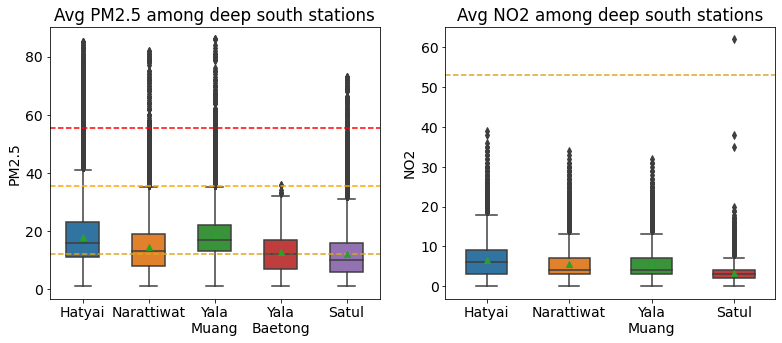

In [76]:
fig, ax = plt.subplots(1,2, figsize=(13, 5))

bplot1 = sns.boxplot(x='variable', y='value', data=pm25_all, width=0.5, ax=ax[0], showmeans=True )
bplot2 = sns.boxplot(x='variable', y='value', data=no2_all, width=0.5, ax=ax[1], showmeans=True)

title_list = ['Avg PM2.5 among deep south stations', 'Avg NO2 among deep south stations']
ylabel_list = ['PM2.5', 'NO2']
for a, title, ylabel in zip(ax, title_list, ylabel_list):
    a.set_title(title)
    a.set_xlabel(None)
    a.set_ylabel(ylabel)
    
# aqiline
ax[0].axhline(12, color='goldenrod', linestyle='dashed')
ax[0].axhline(35.4, color='orange', linestyle='dashed')
#ax[0].axhline(55.4, color='red', linestyle='dashed')
ax[0].axhline(55.4, color='red', linestyle='dashed')


ax[1].axhline(53, color='goldenrod', linestyle='dashed')

plt.savefig(dataset.report_folder + 'compare_deep_south_stations.png')

# PM2.5 Model

In [11]:
dataset = Dataset('Hat Yai')

=================find the best RF model=================
best rf score  -0.32207240566495793
val score after op_rf {'val_r2_score': -0.0652, 'val_r2': 0.1279, 'val_mean_squared_error': 313.9426, 'val_mean_absolute_error': 11.0889, 'val_mean_absolute_percentage_error': 43.5372, 'val_median_absolute_error': 5.336}
test score after op_rf {'test_r2_score': -0.1738, 'test_r2': 0.0678, 'test_mean_squared_error': 50.8709, 'test_mean_absolute_error': 5.5918, 'test_mean_absolute_percentage_error': 41.5103, 'test_median_absolute_error': 4.6958}
================ remove unncessary columns no lag=================



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.37s/it]


score after dropping columns  {'r2_score': -0.0652, 'r2': 0.1279, 'mean_squared_error': 313.9426, 'mean_absolute_error': 11.0889, 'mean_absolute_percentage_error': 43.5372, 'median_absolute_error': 5.336}
export figure as  C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/hat_yai/_PM25_rf_fea_op2.png
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 20 mins
new fire parameter {'w_speed': 1.7, 'shift': 72, 'roll': 240, 'damp_surface': 1.0, 'wind_damp': 1, 'wind_lag': 0, 'split_direct': 0} give score = 218.11852656402974
op fire give val score {'val_r2_score': 0.0089, 'val_r2': 0.2468, 'val_mean_squared_error': 220.1636, 'val_mean_absolute_error': 10.4518, 'val_mean_absolute_percentage_error': 42.4766, 'val_median_absolute_error': 5.0219}
op fire give test score {'test_r2_score': -0.065, 'test_r2': 0.1314, 'test_mean_squared_error': 66.0412, 'test_mean_absolute_error': 5.3956, 'test_mean_absolute_perce


  0%|                                                                                          | 0/255 [00:00<?, ?it/s]

op4 test score {'test_r2_score': -0.0714, 'test_r2': 0.1567, 'test_mean_squared_error': 65.6119, 'test_mean_absolute_error': 5.4207, 'test_mean_absolute_percentage_error': 40.5078, 'test_median_absolute_error': 4.6322}
================= remove unncessary lag columns =================



 26%|████████████████████▉                                                            | 66/255 [16:56<50:13, 15.94s/it]


 52%|█████████████████████████████████████████▍                                      | 132/255 [34:49<34:44, 16.94s/it]


 78%|██████████████████████████████████████████████████████████████                  | 198/255 [54:38<20:07, 21.18s/it]


100%|██████████████████████████████████████████████████████████████████████████████| 255/255 [1:11:43<00:00, 16.87s/it]


score after dropping columns  {'r2_score': 0.1452, 'r2': 0.4226, 'mean_squared_error': 190.0712, 'mean_absolute_error': 9.5314, 'mean_absolute_percentage_error': 38.3279, 'median_absolute_error': 4.575}
best rf score  -0.010758050636842076
val score after op6 {'val_r2_score': 0.1194, 'val_r2': 0.4097, 'val_mean_squared_error': 195.8006, 'val_mean_absolute_error': 9.6399, 'val_mean_absolute_percentage_error': 37.9498, 'val_median_absolute_error': 4.5214}
test score after op6  {'testop6_r2_score': -0.0513, 'testop6_r2': 0.1621, 'testop6_mean_squared_error': 64.3802, 'testop6_mean_absolute_error': 5.3286, 'testop6_mean_absolute_percentage_error': 39.684, 'testop6_median_absolute_error': 4.5193}
final score for test set {'test_r2_score': -0.0684, 'test_r2': 0.1766, 'test_mean_squared_error': 65.4279, 'test_mean_absolute_error': 5.3882, 'test_mean_absolute_percentage_error': 40.6243, 'test_median_absolute_error': 4.5521}
daily avg score for test set {'avg_test_r2_score': -0.2922, 'avg_test_

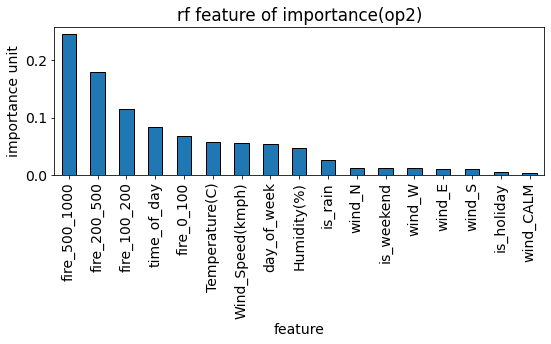

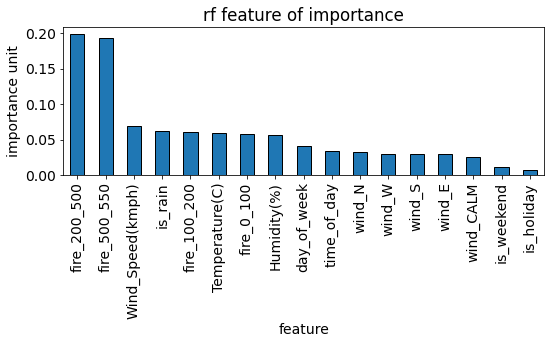

In [12]:
%%time
filename = dataset.model_folder + 'PM25_model_meta.json'
model_meta = load_meta(filename)
model_meta['rolling'] = 1
model_meta['zone_list'] = [0, 100, 200, 500, 1000]
model_meta['cat_hour'] = 0
model_meta['cat_month'] = 0
model_meta['split_lists'] = [[0.55, 0.2, 0.25], [0.55, 0.2, 0.25], [0.75, 0.25]]

save_meta(filename, model_meta)
# training 24 hour avg center
dataset, model, trainer = train_city_s1(city='Hat Yai', pollutant= 'PM2.5', instr='MODIS', add_weight=True, op_fire_zone=True, op_lag=True, choose_cat_hour=True, choose_cat_month=False)

raw model performance {'test_r2_score': -0.063, 'test_r2': 0.1801, 'test_mean_squared_error': 64.9846, 'test_mean_absolute_error': 5.3693, 'test_mean_absolute_percentage_error': 40.4781, 'test_median_absolute_error': 4.5657}
daily avg training error {'avg_trn_r2_score': 0.9788, 'avg_trn_r2': 0.9933, 'avg_trn_mean_squared_error': 1.0135, 'avg_trn_mean_absolute_error': 0.7719, 'avg_trn_mean_absolute_percentage_error': 5.1101, 'avg_trn_median_absolute_error': 0.627}
daily avg test error {'avg_test_r2_score': -0.2781, 'avg_test_r2': 0.087, 'avg_test_mean_squared_error': 29.8091, 'avg_test_mean_absolute_error': 4.304, 'avg_test_mean_absolute_percentage_error': 30.5681, 'avg_test_median_absolute_error': 3.5987}


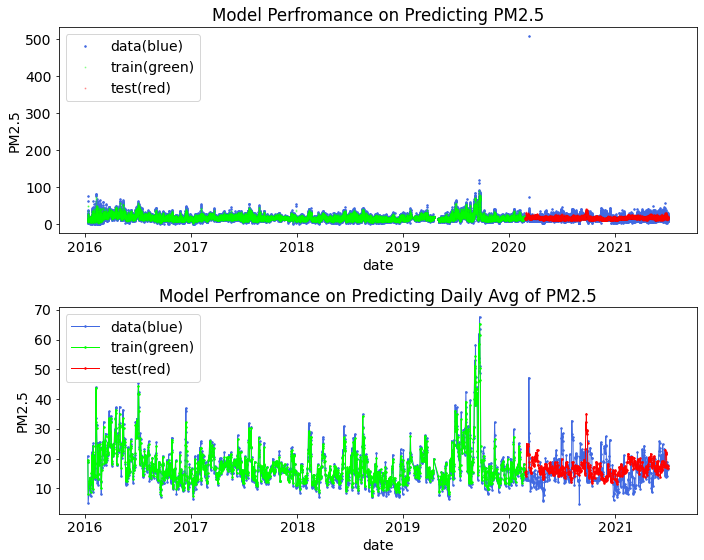

In [17]:
dataset, model, fire_cols, zone_list, feat_imp, rolling_win = load_model(city='Hat Yai', pollutant='PM2.5' )
_, df = plot_model_perf(dataset=dataset, model= model, split_list=model_meta['split_lists'][-1], xlim=[], to_save=True)

Model performance vs seasonal pattern and residue

In [19]:
# calculate the average error for the test data
ytest_pred_df = cal_error(dataset, model, data_index=dataset.split_list[1])
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()

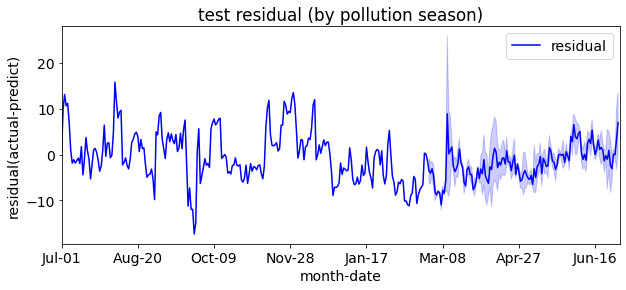

In [20]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(ytest_pred_df, 'residual', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('test residual (by pollution season)')
ax.set_ylabel('residual(actual-predict)')
plt.savefig(dataset.report_folder + 'PM25_season_residual.png', dpi=300 )

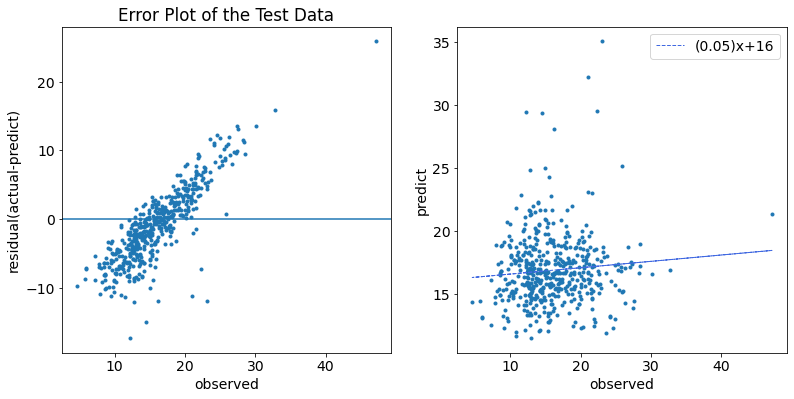

In [21]:
# plot residual vs actual value
_, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['residual'], marker='.')
ax[0].set_ylabel('residual(actual-predict)')
ax[0].set_xlabel('observed')
ax[0].axhline(0)
ax[0].set_title('Error Plot of the Test Data')

ax[1].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['pred'], marker='.')
ax[1].set_ylabel('predict')
ax[1].set_xlabel('observed')
#ax[1].set_title('Error Plot of the Test Data')
s = ytest_pred_df_avg['pred']
s.index = ytest_pred_df_avg['actual']
add_ln_trend_line(s, ax=ax[1])
ax[1].legend()
plt.savefig(dataset.report_folder + 'PM25_residual.png', dpi=300 )